# Advanced transfer learning

In [1]:
### Import modules
# Data
from google.colab import files
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
# Models
import tensorflow as tf
import numpy as np
from transformers import AlbertTokenizer, TFAutoModelForSequenceClassification
import transformers
import keras
# Plots
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
### Set seed to ensure reproducibility
tf.keras.utils.set_random_seed(1234)

### Warmup: Data loading

✍ **DESCRIPTION OF THE CODE**

Link to the dataset (Kaggle): https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

The **News Headlines Dataset For Sarcasm Detection** is composed of 28619 rows. Each row has a text and a label. Each text, according to the label, can either be *sarcastic* or *non-sarcastic*.

The headlines (instead of being collected from Twitter and manually labelled) were extracted from two known english news websites: *TheOnion* and *HuffPost*. *TheOnion* aims at producing sarcastic versions of current events; all the headlines were collected from News in Brief and in Photos categories (which are sarcastic).
The real (and non-sarcastic) news headlines were collected from *HuffPost*.

We are dealing with a **binary text classification task**.

In [2]:
### Load data directly from kaggle and unzip
uploaded = files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection
!unzip -q news-headlines-dataset-for-sarcasm-detection.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.30M/3.30M [00:01<00:00, 3.53MB/s]
100% 3.30M/3.30M [00:01<00:00, 2.64MB/s]


In [3]:
### Read data and store as pandas dataframe
data_list = []
with open("Sarcasm_Headlines_Dataset_v2.json", "r") as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

df = pd.DataFrame(data_list)
df.drop(['article_link'], axis=1, inplace=True) # do not need the article_link column
y = df['is_sarcastic']
Counter(y) # the dataset is balanced

Counter({1: 13634, 0: 14985})

In [4]:
### Data examples
sarcastic_df = df[df['is_sarcastic'] == 1]
not_sarcastic_df = df[df['is_sarcastic'] == 0]

print(f"Sarcastic examples: {sarcastic_df.head(2)['headline'].to_list()}")
print(f"Non sarcastic examples: {not_sarcastic_df.head(2)['headline'].to_list()}")

Sarcastic examples: ['thirtysomething scientists unveil doomsday clock of hair loss', 'inclement weather prevents liar from getting to work']
Non sarcastic examples: ['dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes']


In [5]:
texts = df["headline"].tolist()
labels = df["is_sarcastic"].tolist()

# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=32, stratify=labels)

# Split train set into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=32, stratify=train_labels)

### LoRA

✍ **DESCRIPTION OF THE CODE**

**ALBERT model**

For the final project I chose the [*ALBERT*](https://arxiv.org/pdf/1909.11942) *Tranformer large language model*, whose official paper entitled "**Lite BERT** for self-supervised learning of language representations" was published in 2020.

The pre-trained [albert-base-v2](https://huggingface.co/albert/albert-base-v2) model was imported through the `transformers` library.
* Uncased, as for all ALBERT models.
* Just like BERT, it has an "encoder-only" transformer architecture with GELU non-linearities.
* Repeating encoder layers: $\text{L} = 12$
* Embedding dimension: $\text{E} = 128$
* Hidden dimension: $\text{H} = 768$
* Number of attention heads: $\text{h} = \frac{\text{H}}{64} = \frac{768}{64} = 12$
* 11M parameters.
* Differently from BERT, token embedding is decoupled from the hidden dimension. In fact, $\text{E} \neq \text{H}$.

ALBERT is particular in that it shares its layers across its Transformer layers (cross-layer parameter sharing i.e., sharing parameters across multiple layers of the model, including the attention mechanisms). Therefore, all layers have the same weights (fewer parameters). Using repeating layers results in a small memory footprint, however, the computational cost remains similar to a BERT-like architecture with the same number of hidden layers as it has to iterate through the same number of (repeating) layers.

In [6]:
# Source 1: https://github.com/huggingface/transformers/blob/main/src/transformers/models/albert/modeling_albert.py

tf.keras.utils.set_random_seed(1234)
base_model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2) # a classification head with 2 classes has been added

for layer in base_model.layers:
  if layer.name == 'classifier':
    layer.trainable = True
  else:
    layer.trainable = False

base_model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683584  
                                                                 
 dropout_4 (Dropout)         multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 11685122 (44.58 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 11683584 (44.57 MB)
_________________________________________________________________


#### **Prepare the data**

We cannot directly feed the texts to neural networks, but we must convert them to a numerical form so that our model can "understand" and interpret the data. We tokenize our texts with `AlbertTokenizer`, making sure that we return tensorflow tensors and ensuring that all sequences are the same length (through right-padding, therefore padding shorter sequences with zeros). Moreover, to accomodate the computational constraints of the GPU, we set a maximum length for our sequences during tokenization.

In [7]:
# Tokenize all texts (return Tensorflow tensors and make sure that all embeddings are the same length)
# from raw strings to integer sequences (matching ALBERT models vocabulary and recognizing ALBERT special tokens)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', force_download=True) # force_download=True to avoid deprecation warning
train_encodings = tokenizer(train_texts, padding=True, return_tensors='tf', truncation=True, max_length=128)
val_encodings = tokenizer(val_texts, padding=True, return_tensors='tf', truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, return_tensors='tf', truncation=True, max_length=128)
# Dictionary-like structure
# input_ids: tokenID corresponding to the text
# attention_mask: ignore padding tokens which we used to make the sequences the same length
# token_type_ids: all zeros in our case as we have only single segments (just text classification task, no question answering or text generation)

def create_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Create TensorFlow datasets
train_dataset = create_dataset(train_encodings, train_labels)
val_dataset = create_dataset(val_encodings, val_labels)
test_dataset = create_dataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [8]:
# Mantain the same distribution of labels using the stratify option in train_test_split
print(f'The number of training data points is {len(train_labels)} with distribution {Counter(train_labels.numpy())}')
print(f'The number of validation data points is {len(val_labels)} with distribution {Counter(val_labels.numpy())}')
print(f'The number of test data points is {len(test_labels)} with distribution {Counter(test_labels.numpy())}')

The number of training data points is 20605 with distribution Counter({0: 10789, 1: 9816})
The number of validation data points is 2290 with distribution Counter({0: 1199, 1: 1091})
The number of test data points is 5724 with distribution Counter({0: 2997, 1: 2727})


#### **Train the classification head of `base_model`**

As the classification head weights [`classifier.weight`, `classifier.bias`] in the pre-trained `base_model` were newly initialzed, they are random and essentially hold no meaningful information. Therefore, they must be trained on our task before applying our advanced transfer learning method i.e., LoRA.

In [9]:
batch_size = 64
predictions = base_model.predict(test_dataset.batch(batch_size), verbose=0)
predicted_labels = tf.argmax(predictions.logits, axis=-1).numpy()
accuracy = np.mean(predicted_labels == test_labels)
print(f'Test Accuracy of base model before training the classification head: {accuracy:.4f}')
print(Counter(predicted_labels)) # almost always predicts 'non-sarcastic'

Test Accuracy of base model before training the classification head: 0.5210
Counter({0: 5699, 1: 25})


In [11]:
tf.keras.utils.set_random_seed(1234)
## Compile the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
base_model.compile(loss=loss, metrics=["sparse_categorical_accuracy"])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
num_epochs = 5

## Train the model
print('Training: ')
history = base_model.fit(train_dataset.shuffle(100).batch(batch_size),
                            epochs=num_epochs, verbose=1,
                            validation_data=val_dataset.batch(batch_size),
                            callbacks=[early_stop])

Training: 
Epoch 1/5
322/322 [==============================] - 239s 633ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.5932 - val_sparse_categorical_accuracy: 0.6830
Epoch 2/5
322/322 [==============================] - 194s 603ms/step - loss: 0.5899 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.5624 - val_sparse_categorical_accuracy: 0.7127
Epoch 3/5
322/322 [==============================] - 194s 602ms/step - loss: 0.5809 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.7297
Epoch 4/5
322/322 [==============================] - 194s 602ms/step - loss: 0.5747 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.5538 - val_sparse_categorical_accuracy: 0.7148


In [27]:
base_model.save_weights('base_model_weights.h5')

#### **Build LoRA layers and define `lora_model`**

I decided to implement a PEFT re-parametrization technique i.e., LoRA (Low Rank Adaptation). The idea is that we freeze all pre-trained model weights, not only a subset of weights, such that the internal model parameters stay the same, while we augument the model with additional parameters which instead are trainable. Equivalently, we can re-parameterize a subset of the original model parameters with low-dimensional proxy parameters, and just optimize the proxy.

It has been empirically proven that "pre-trained language models have a low “instrisic dimension” and can still learn efficiently despite a random projection to a smaller subspace". Therefore, based on this idea, we can hypothesize that the LLM weight matrices are low-rank and also that the updates to the weights have low "intrinsic rank" during adaptation.

By following the implementation of the [official paper](https://arxiv.org/pdf/2106.09685) we adapt the query and value projection matrices in the self-attention layer of our ALBERT model, while freezing the original query and value trainable parameters. In our case, the original query and value projection matrices have a (768, 768) dimension for a total of 589824 parameters each. With LoRA we can define two matrices such that their product yields a matrix of weights of the same shape of the original one. For instance, when choosing a rank $r$=4 we have a matrix $\text{A}$ having dimension (4, 768) and a matrix $\text{B}$ having dimension (768, 4) such that matrix $\text{BA}$ has shape (768, 768). However, now, we have to train only 2\*768\*4=6144 trainable parameters instead of 589824 trainable parameters of the original model.

$$\text{Updated output: $\text{h(x)}$ = original output + lora output = $\text{W}x + \text{BA}x$}$$

where $\text{W}$ is the original matrix of weights. Like in the paper we use a random Gaussian initialization for $\text{A}$ and zero for $\text{B}$, so $\text{BA}$ is zero at the beginning of training.

One of the down-sides of LoRA is that there are many hyperparameters that can be chosen:
* the **rank** can take any value such that $r > 0$ and $r \ll \text{min}(d, k)$ where $\text{W} \in \mathbb{R}^{d \times k}$. In our case, $d=k=768$. I chose $r=4$ as it yields satisfactory results in combination with the other chosen hyperparameters.
* the **initialization** of the matrices $\text{A}$ and $\text{B}$. I decided to stick with the one cited in the paper, as previously stated.
* **where to apply**, inject the LoRA components. The results of the paper show that updating query and value matrices performes better than updating only one matrix even at lower ranks.

In [13]:
# Source 1: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing
# Source 2: https://keras.posit.co/reference/Layer.html
# Source 3: https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/

class LoraLayer(tf.keras.layers.Layer):
    def __init__(self, original_layer, rank = 4, **kwargs):
      super(LoraLayer, self).__init__(**kwargs)

      self.original_layer = original_layer
      self.original_layer.trainable = False # freeze original query and value layers
      self.rank = rank
      config = self.original_layer.get_config()

      n = self.original_layer.kernel.shape[0]

      # initialize LoRA parameters and set as trainable
      self.lora_A = self.add_weight(name='lora_A', shape=(self.rank, n), initializer='random_normal', trainable=True)
      self.lora_B = self.add_weight(name='lora_B', shape=(n, self.rank), initializer='zeros', trainable=True)

      # Check correct shape
      print(f'Shape of matrix Lora A for {config["name"]}: {self.lora_A.shape}')
      print(f'Shape of matrix Lora B for {config["name"]}: {self.lora_B.shape}')

    def call(self, inputs):
      # updated output with LoRA weights: h(x) = (W + deltaW)x = original output + lora output where deltaW=BA
      return self.original_layer(inputs) + tf.linalg.matmul(inputs, tf.linalg.matmul(self.lora_B, self.lora_A))

I needed to define a `LoraCustomAlbert` class with customized `train_step` and `call` instance methods to define our `lora_model`. I further added some additional methods such as `get_trainable_weights` and `num_lora_parameters` which respectively return the current trainable weights and the number of LoRA parameters (all trainable).


In [28]:
# Source 1: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
# Source 2: https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/
# Source 3: https://www.tensorflow.org/guide/keras/training_with_built_in_methods

class LoraCustomAlbert(keras.Model):
    def __init__(self, rank, base_model, learning_rate=0.001):
        super(LoraCustomAlbert, self).__init__()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

        # pre-trained base model (for binary classification)
        self.base_model = base_model
        self.albert_layer = self.base_model.albert

        # freeze all pre-trained model weights within the Albert model
        for layer in self.albert_layer.submodules:
            layer.trainable = False

        print()
        for layer in self.albert_layer.submodules:
            if isinstance(layer, transformers.models.albert.modeling_tf_albert.TFAlbertAttention):
              # attention mechanism
              attention_layer = layer
              query_layer = attention_layer.query
              value_layer = attention_layer.value
              # query and value LoRA layers
              # these matrices are utilized by multiple attention heads (parameter sharing)
              self.query_lora_layer = LoraLayer(query_layer, rank=rank)
              self.query_lora_layer._name = 'Lora_q'
              self.value_lora_layer = LoraLayer(value_layer, rank=rank)
              self.value_lora_layer._name = 'Lora_v'
              # inject the LoRA matrices
              attention_layer.query = self.query_lora_layer
              attention_layer.value = self.value_lora_layer

        print()
        print('Multiple checks to ensure that only LoRA layers are trainable')
        print('Trainable Albert weights:')
        for layer in self.albert_layer.submodules:
          temp_list = [weight.name for weight in layer.trainable_weights]
          if len(temp_list) > 1:
            print(temp_list)
        print('Trainable Albert layers:')
        for layer in self.albert_layer.submodules:
          if layer.trainable:
            print(layer.name)

        # should already be set to False
        self.base_model.classifier.trainable = False
        self.base_model.dropout.trainable = False

        # keep a list of all trainable weights (i.e., only LoRA weights)
        self.my_trainable_weights = []
        for layer in self.albert_layer.submodules:
          self.my_trainable_weights.extend(layer.trainable_weights)
        print('Names of trainable weights in my list of trainable weights:', [weight.name for weight in self.my_trainable_weights])

    # modify the training step with new trainable weights
    def train_step(self, data):
        inputs, labels = data
        with tf.GradientTape() as tape:
            outputs = self.base_model(**inputs, training=True) # forward pass: compute model output
            logits = outputs.logits
            loss = self.compiled_loss(labels, logits) # in the compiled loss we set "from_logits=True"
        # backwards pass
        gradients = tape.gradient(loss, self.my_trainable_weights) # compute the gradients of the loss with respect to the model’s trainable weights
        self.optimizer.apply_gradients(zip(gradients, self.my_trainable_weights)) # update parameter values
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics} # return loss (sparse categorical crossentropy) and sparse_categorical_accuracy values

    # customize call function (base_model)
    def call(self, inputs, training=False):
        return self.base_model(**inputs, training=training)

    def get_trainable_weights(self):
      return self.my_trainable_weights

    def num_lora_parameters(self):
      num_trainable_parameters = 0
      for arr in self.my_trainable_weights:
        num_trainable_parameters += arr.numpy().reshape(-1).shape[0]
      return num_trainable_parameters

In [29]:
tf.keras.utils.set_random_seed(1234)
# low intrinstic rank
print('RANK=4 LORA MODEL') # rank 4 yields already great results and increasing it to 8 does not visibly improve the model

original_model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
original_model.load_weights('base_model_weights.h5')
original_model.trainable = False
lora_model_r4 = LoraCustomAlbert(rank=4, base_model=original_model, learning_rate=0.001)

RANK=4 LORA MODEL


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Shape of matrix Lora A for query: (4, 768)
Shape of matrix Lora B for query: (768, 4)
Shape of matrix Lora A for value: (4, 768)
Shape of matrix Lora B for value: (768, 4)

Multiple checks to ensure that only LoRA layers are trainable
Trainable Albert weights:
['lora_A:0', 'lora_B:0']
['lora_A:0', 'lora_B:0']
Trainable Albert layers:
Lora_q
Lora_v
Names of trainable weights in my list of trainable weights: ['lora_A:0', 'lora_B:0', 'lora_A:0', 'lora_B:0']


In [30]:
print(f'Number of LoRA trainable parameters with rank=4: {lora_model_r4.num_lora_parameters()}') # vs 2*768*768=1,179,648 original parameters

Number of LoRA trainable parameters with rank=4: 12288


In [31]:
lora_model_r4.get_trainable_weights() # before training

ListWrapper([<tf.Variable 'lora_A:0' shape=(4, 768) dtype=float32, numpy=
array([[-0.04024116,  0.03047589,  0.04350131, ...,  0.10628819,
         0.02707832,  0.04128957],
       [ 0.02387177, -0.0643924 ,  0.00322855, ..., -0.03422604,
        -0.01351881, -0.02375426],
       [ 0.05051091,  0.06913877, -0.05276849, ...,  0.06113426,
         0.05384082, -0.0879037 ],
       [ 0.00013123, -0.04606956, -0.04689973, ..., -0.01983148,
         0.0581385 ,  0.03658329]], dtype=float32)>, <tf.Variable 'lora_B:0' shape=(768, 4) dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>, <tf.Variable 'lora_A:0' shape=(4, 768) dtype=float32, numpy=
array([[-0.02016698,  0.00048892, -0.01410156, ...,  0.06038123,
        -0.01205856,  0.00050438],
       [-0.05061669,  0.10763893,  0.07429618, ...,  0.0008703 ,
        -0.07222711, -0.01492883],
      

#### **Train `lora_model`**

For this task a high number of epochs is not necessary as training and validation accuracy fastly increase (and loss decreases) after one epoch, and the validation loss starts to increase after the fourth epoch (early stopping kicks in).

In [32]:
### RANK=4
tf.keras.utils.set_random_seed(1234)

## Compile the model
# no need for one-hot encodings as task is binary so we can use the sparse categorical crossentropy and accuracy
# model gives logits in output
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # from_logits=True to avoid numerical issues from the use of the exp, more stable
lora_model_r4.compile(loss=loss, metrics=["sparse_categorical_accuracy"])
# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

## Mini-batch gradient descent
# batch_size: number of training examples used in one iteration to update the model parameters
# (number of training examples/batch_size) gives the number of iterations needed to complete one epoch
batch_size = 64 # cannot run with batch size=128 as it requires too much memory and computational power (GPU)
# completing an epoch means that the learning algorithm has made one full pass through the entire dataset
num_epochs = 10

## Evaluate the model before training
train_loss, train_accuracy = lora_model_r4.evaluate(train_dataset.batch(batch_size), verbose=0)
print(f'Loss before training: {train_loss:.4f}')
print(f'Accuracy before training: {train_accuracy:.4f}')
print()

## Train the model
# Instead of randomly sampling batches from the training dataset at each iteration:
# 1) shuffle the full dataset
# 2) split the dataset into blocks of 64 (batch_size) elements and process them sequentially
# 3) after completed an epoch return to 1) until we have reached the num_epochs or other stoppping criterion
# Here we need 322 iterations (mini-batches) to complete an epoch
print('Training: ')
history = lora_model_r4.fit(train_dataset.shuffle(100).batch(batch_size),
                            epochs=num_epochs, verbose=1,
                            validation_data=val_dataset.batch(batch_size),
                            callbacks=[early_stop])

## Evaluate the model after training
print()
train_loss, train_accuracy = lora_model_r4.evaluate(train_dataset.batch(batch_size), verbose=0)
print(f'Loss after training: {train_loss:.4f}')
print(f'Accuracy after training: {train_accuracy:.4f}')

Loss before training: 0.5523
Accuracy before training: 0.7223

Training: 
Epoch 1/10
322/322 [==============================] - 473s 1s/step - loss: 0.4538 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.3249 - val_sparse_categorical_accuracy: 0.8598
Epoch 2/10
322/322 [==============================] - 442s 1s/step - loss: 0.2927 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.8895
Epoch 3/10
322/322 [==============================] - 441s 1s/step - loss: 0.2448 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.2541 - val_sparse_categorical_accuracy: 0.8956
Epoch 4/10
322/322 [==============================] - 442s 1s/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 0.8991
Epoch 5/10
322/322 [==============================] - 441s 1s/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.2985 - val_sparse_categorical_accuracy: 0.8764
Epoch 6/10
322/322 [=

In [33]:
# check that weights have changed
lora_model_r4.get_trainable_weights() # after training

ListWrapper([<tf.Variable 'lora_A:0' shape=(4, 768) dtype=float32, numpy=
array([[ 0.05010508,  0.04364596,  0.06297856, ...,  0.19670464,
        -0.01041685, -0.01653913],
       [ 0.01126462, -0.17392947,  0.0509535 , ..., -0.02271234,
         0.06649283, -0.04482936],
       [-0.03372956,  0.06099809,  0.002925  , ...,  0.06422238,
         0.054857  , -0.10590455],
       [ 0.03721963, -0.04999409, -0.08766777, ..., -0.10278478,
         0.05885093,  0.07873525]], dtype=float32)>, <tf.Variable 'lora_B:0' shape=(768, 4) dtype=float32, numpy=
array([[-0.12004127, -0.01016141, -0.05792761,  0.08602048],
       [ 0.03710642,  0.03049427, -0.00350597,  0.01907025],
       [-0.00889937, -0.05416471,  0.00375575,  0.04284374],
       ...,
       [ 0.1709196 , -0.02738574,  0.02236033,  0.09387621],
       [-0.04908698,  0.00127423, -0.03783989,  0.02226138],
       [ 0.02299672, -0.04187552, -0.06106384,  0.01050416]],
      dtype=float32)>, <tf.Variable 'lora_A:0' shape=(4, 768) dtype=

#### **Evaluate `lora_model`**

We can evaluate the trained `lora_model` and compare it with the `base_model`. It can clearly be seen that there has been an improvement in accuracy w.r.t. the `base_model`. Moreover, the model no longer misclassifies as many non-sarcastic examples as sarcastic (look at the specificity values). We can conclude that, in our case, LoRA has successfully improved our original pre-trained model.

Test Accuracy of base model: 0.7152
Specificity: 0.5963
Sensitivity (Recall): 0.8460


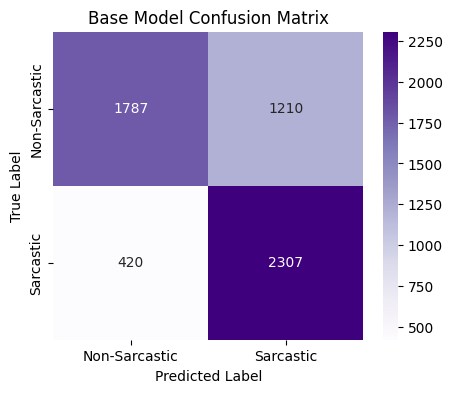


Test Accuracy of Lora model with rank=4 after training: 0.9044
Specificity: 0.9219
Sensitivity (Recall): 0.8852


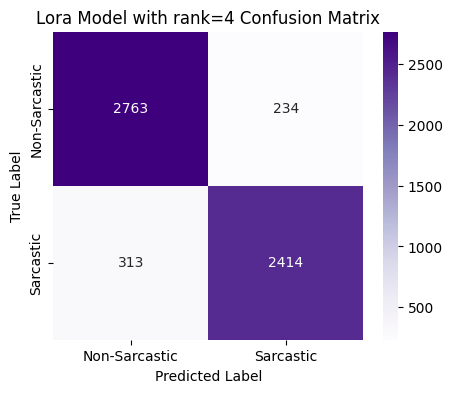

In [34]:
# Base model
predictions = base_model.predict(test_dataset.batch(batch_size), verbose=0)
predicted_labels = tf.argmax(predictions.logits, axis=-1).numpy()
accuracy = np.mean(predicted_labels == test_labels)
print(f'Test Accuracy of base model: {accuracy:.4f}')
tn, fp, fn, tp = confusion_matrix(test_labels.numpy(), predicted_labels).ravel()
print(f'Specificity: {tn/(tn + fp):.4f}') # true negatives/all negatives
print(f'Sensitivity (Recall): {tp/(tp + fn):.4f}') # true positives/all positives
conf_matrix = confusion_matrix(test_labels.numpy(), predicted_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Base Model Confusion Matrix')
plt.show()
print()

# LoRA model
predictions = lora_model_r4.predict(test_dataset.batch(batch_size), verbose=0)
predicted_labels = tf.argmax(predictions.logits, axis=-1).numpy()
accuracy = np.mean(predicted_labels == test_labels)
print(f'Test Accuracy of Lora model with rank=4 after training: {accuracy:.4f}')
tn, fp, fn, tp = confusion_matrix(test_labels.numpy(), predicted_labels).ravel()
print(f'Specificity: {tn/(tn + fp):.4f}') # true negatives/all negatives
print(f'Sensitivity (Recall): {tp/(tp + fn):.4f}') # true positives/all positives
conf_matrix = confusion_matrix(test_labels.numpy(), predicted_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Lora Model with rank=4 Confusion Matrix')
plt.show()